<a href="https://colab.research.google.com/github/bhomaidan1990/Computer_Vision_Labs/blob/main/CV_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision, Lab(3)
## construct sliding windows multi-scale

In [1]:
##########################
# @Authors:              #
#     Belal Hmedan       #
# &   Junyi ZHONG        #
##########################
#
#========================
# Import Libraries
#========================
import os
import glob
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle
from keras.preprocessing import image
import cv2
import time
import math
import keras 
import tensorflow as tf
from keras import layers
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import imutils

### Reproducible Code Initialization

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

### Get the Dataset Online

In [3]:
#=======================
# Download the dataset
#=======================
!rm originalPics.tar.gz & rm FDDB-folds.tgz & rm test_db.zip
!rm -rf Dataset & rm -rf FDDB-folds & rm -rf sample_data & rm -rf NewDataset
#
!wget http://tamaraberg.com/faceDataset/originalPics.tar.gz
!wget http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
#-----------------------
# Test_Data
#==================
!wget http://crowley-coutaz.fr/jlc/Courses/2020/GVR.VO/test_db.zip
!unzip test_db.zip & mv TestTest test
!rm test_db.zip
#-----------------------------------------------------------
# Extract the data
#==================
t0 = time.time()
!mkdir original && tar xvzf originalPics.tar.gz -C original
!rm originalPics.tar.gz
!tar xvzf FDDB-folds.tgz
!rm FDDB-folds.tgz
t1 = time.time()
print('DeCompressing Time is : ',t1-t0," seconds")
# create the output dataset folder
#-----------------------------------------------------------
if (not os.path.isdir('Dataset')):
    os.mkdir('Dataset')
#-------------------------------------------------
for im in glob.glob('/content/original/**/*.jpg', recursive=True):
    # print(im)
    shutil.copy(im, 'Dataset')
# !rm -rf original
#-------------------------------------------------

Streaming output truncated to the last 5000 lines.
2003/07/07/big/img_908.jpg
2003/07/01/big/img_250.jpg
2003/05/28/big/img_52.jpg
2002/11/06/big/img_476.jpg
2003/04/17/big/img_859.jpg
2002/09/30/big/img_903.jpg
2002/11/20/big/img_854.jpg
2003/02/23/big/img_874.jpg
2003/06/12/big/img_29.jpg
2003/03/10/big/img_518.jpg
2002/07/24/big/img_789.jpg
2003/03/10/big/img_327.jpg
2003/06/03/big/img_331.jpg
2002/09/04/big/img_13147.jpg
2002/07/23/big/img_306.jpg
2002/10/17/big/img_577.jpg
2002/08/08/big/img_981.jpg
2002/11/25/big/img_499.jpg
2002/12/18/big/img_347.jpg
2002/07/22/big/img_602.jpg
2003/07/17/big/img_341.jpg
2002/11/18/big/img_608.jpg
2003/07/02/big/img_367.jpg
2003/05/23/big/img_411.jpg
2002/12/10/big/img_717.jpg
2002/11/01/big/img_694.jpg
2002/11/26/big/img_258.jpg
2002/09/18/big/img_884.jpg
2002/10/22/big/img_1198.jpg
2003/03/10/big/img_748.jpg
2002/12/06/big/img_921.jpg
2003/07/18/big/img_30.jpg
2002/11/24/big/img_830.jpg
2002/11/01/big/img_193.jpg
2002/07/26/big/img_207.jpg
2003

In [4]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [5]:
# Local Jupyter conda env
# pip install imutils
# !pip install -U scikit-image

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


image size: (450, 235, 3)


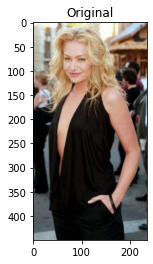

In [7]:
plt.figure()
imgPath = "Dataset/img_3044.jpg"

img = cv2.imread(imgPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title('Original')
print('image size:',img.shape)

image size (450, 235, 3)
image size (225, 118, 3)
image size (113, 59, 3)
image size (57, 30, 3)


<Figure size 432x288 with 0 Axes>

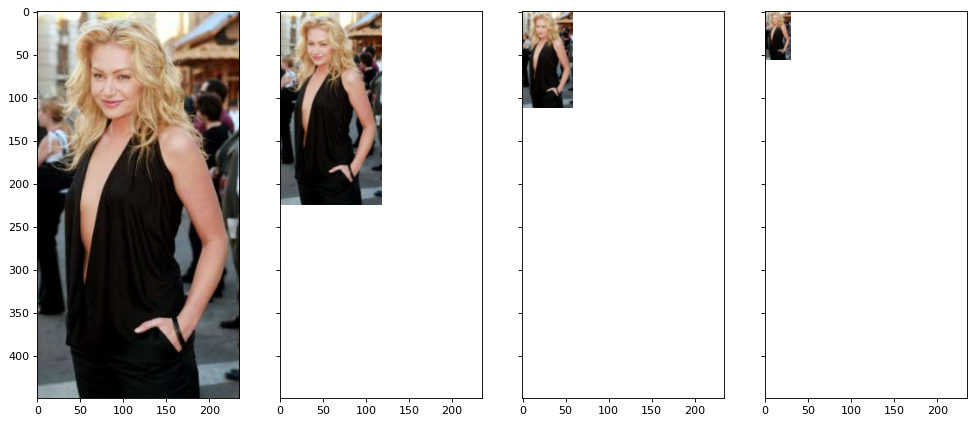

In [8]:
# Down sampling
plt.figure()
pyramid = []
dst = img
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(15,8),dpi=80,sharex=True,sharey=True)

pyramid.append(dst)
for i in range(0,3):
    dst = cv2.pyrDown(dst)
    pyramid.append(dst)

for i in range(len(pyramid)-1,-1,-1):
    print('image size',pyramid[len(pyramid)-1-i].shape) # reduce 1/2 image size recursively
    ax[i].imshow(pyramid[i])  

image size (900, 470, 3)


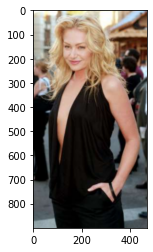

In [9]:
#Up sampling
plt.figure()
dst = cv2.pyrUp(img)
plt.imshow(dst)
print("image size", dst.shape)

image size (57, 30, 3)
image size (114, 60, 3)
image size (228, 120, 3)
image size (456, 240, 3)


<Figure size 432x288 with 0 Axes>

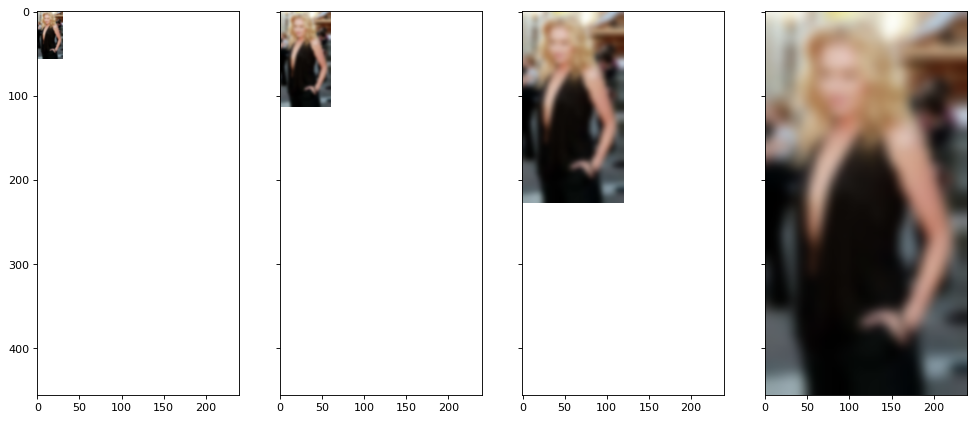

In [10]:
# UP sampling 
plt.figure()
dst = pyramid[3]
pyramid = []
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(15,8),dpi=80,sharex=True,sharey=True)
pyramid.append(dst)
for i in range(0,3): 
    dst = cv2.pyrUp(dst)
    pyramid.append(dst)

for i in range(len(pyramid)):
    print('image size',pyramid[i].shape) # reduce 1/2 image size recursively
    ax[i].imshow(pyramid[i]) 

up sampling and down simpleing inversible process

## Gaussian with intermediate scale
### Gaussian smoothing(example in gray image)

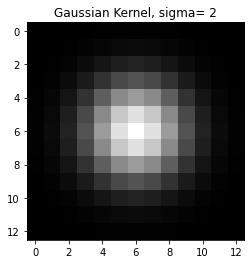

Found 3 Channels : (450, 235, 3)
Converted to Gray Channel. Size : (450, 235)
Kernel Shape : (13, 13)


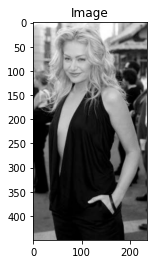

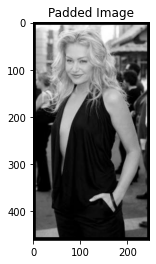

Output Image size : (450, 235)


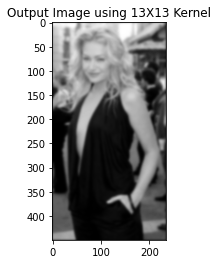

array([[13.53976072, 17.51552932, 20.24637226, ..., 12.48730894,
        10.41525245,  7.84784972],
       [17.51425438, 22.65356316, 26.17956111, ..., 15.50735302,
        12.82167013,  9.59136139],
       [20.22348655, 26.14958688, 30.20575263, ..., 16.94208596,
        13.8491543 , 10.26142224],
       ...,
       [12.53711687, 16.25076086, 18.83463397, ..., 10.17510537,
         8.7652651 ,  6.74970582],
       [10.82310431, 14.02274167, 16.24304991, ...,  8.84871357,
         7.63458931,  5.88552476],
       [ 8.35272305, 10.81758881, 12.52374422, ...,  6.87062456,
         5.936173  ,  4.58058316]])

In [11]:
#ref : http://www.adeveloperdiary.com/data-science/computer-vision/applying-gaussian-smoothing-to-an-image-using-python-from-scratch/
#create a guassian kernel/Filter
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

def gaussian_kernel(size, sigma=2, verbose=False):
 
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    #Compute the outer product of two vectors.
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
    
    #Normalize 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.figure()
        plt.imshow(kernel_2D, interpolation='none',cmap='gray')
        plt.title("Gaussian Kernel, sigma= {}".format(sigma))
        plt.show()
 
    return kernel_2D
#print(gaussian_kernel(5, sigma=2, verbose=True))

#Perform Convolution and average
def convolution(image, kernel, average=False, verbose=False):
    if len(image.shape) == 3:
        print("Found 3 Channels : {}".format(image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        print("Image Shape : {}".format(image.shape))
 
    print("Kernel Shape : {}".format(kernel.shape))
 
    if verbose:
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()
 
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(image.shape)
 
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
 
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
 
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
 
    if verbose:
        plt.figure()
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()
 
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
 
    print("Output Image size : {}".format(output.shape))
 
    if verbose:
        plt.figure()
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()
 
    return output
   
#Gussian smoothing
def gaussian_blur(image, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=2, verbose=verbose)
    return convolution(image, kernel, average=True, verbose=verbose)


image = cv2.imread(imgPath)

gaussian_blur(image, 13, verbose=True)


## Method 1 using imutile library

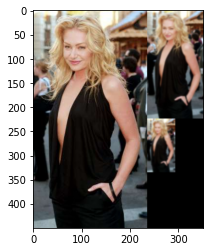

In [12]:
def pyramid_single(image, scale=30):
    # compute the new dimensions of the image and resize it
    w = int(image.shape[1] / scale)
    #Gaussian smoothing 
    image = cv2.GaussianBlur(image,(13,13),2)
    #down sampling
    image = imutils.resize(image, width=w)
    return image

def pyramid(image, scale=1.5, minSize=(30, 30)):
    # yield the original image
    yield image/255
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        #Gaussian smoothing ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
        image = cv2.GaussianBlur(image,(13,13),2)
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image/255   #Clipping input data to the valid range for imshow with RGB data [0..1]


pyramid = tuple(pyramid(img, scale=2))   
rows, cols, dim = img.shape
composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)
composite_image[:rows, :cols, :] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

## Method2 using scikit-image library

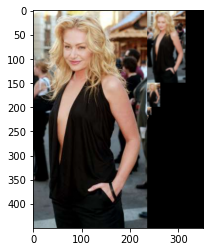

In [14]:
from skimage import transform

rows, cols,dim = img.shape
pyramid = tuple(transform.pyramid_gaussian(img,downscale=3,sigma=3,multichannel=True))

composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)
composite_image[:rows,:cols,:] = pyramid[0]

i_row = 0
for p in pyramid[1:]: 
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig,ax = plt.subplots()
ax.imshow(composite_image)
plt.show()  

## Lapacian pyramid

(450, 234, 3) (450, 234, 3)
(224, 116, 3) (224, 116, 3)
(112, 58, 3) (112, 58, 3)
(56, 28, 3) (56, 28, 3)


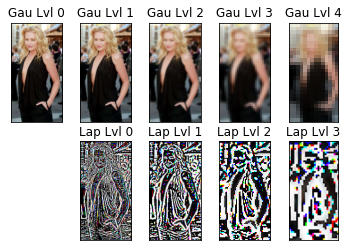

In [15]:
#imgFile = '../2003/01/01/big/img_458.jpg'
 
# load an original image
#img = cv2.imread(imgFile)
################################################################################
 
# color value range
cRange = 256
 
# convert color space from bgr to gray
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
################################################################################
 
# pyramid level
level = 4
 
# original image at the bottom of gaussian pyramid
higherResoGauss = img
plt.subplot(2,1 + level,1), plt.imshow(higherResoGauss), plt.title('Gau Lvl 0'), plt.xticks([]), plt.yticks([])
 
for l in range(level):
    
    rows,cols,channels = higherResoGauss.shape
    
    # delete last odd row of gaussian image
    if rows % 2 == 1:
        higherResoGauss = higherResoGauss[:rows - 1,:]
    # delete last odd column of gaussian image                
    if cols % 2 == 1:
        higherResoGauss = higherResoGauss[:,:cols - 1]
             
    # gaussian image
    lowerResoGauss = cv2.pyrDown(higherResoGauss)    
    # even rows and cols in up-sampled image
    temp = cv2.pyrUp(lowerResoGauss)    
    print (higherResoGauss.shape,temp.shape)
    
    # laplacian image
    lowerResoLap = higherResoGauss - temp   
    
    # display gaussian and laplacian pyramid
    plt.subplot(2,1 + level,l + 2), plt.imshow(lowerResoGauss), plt.title('Gau Lvl ' + '%d' % (l+1)), plt.xticks([]), plt.yticks([])
    plt.subplot(2,1 + level,1 + level + l + 2), plt.imshow(lowerResoLap), plt.title('Lap Lvl ' + '%d' % (l)), plt.xticks([]), plt.yticks([])    
 
    higherResoGauss = lowerResoGauss
################################################################################
               
# display original image and gray image
plt.show()